In [1]:
!pip install numpy pandas scikit-fuzzy matplotlib requests

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import skfuzzy as fuzz
from skfuzzy import control as ctrl

lexicon_path = "Beer Descriptors Simplified.xlsx"
profile_path = "beer_profile_and_ratings.csv"

print("Loading files...")
dfs_lex = pd.read_excel(lexicon_path, sheet_name=None)
beer_df = pd.read_csv(profile_path)

print("Sheets in lexicon:", list(dfs_lex.keys()))
print("Beer dataset shape:", beer_df.shape)
beer_df.head()


Loading files...
Sheets in lexicon: ['Mouthfeel', 'Taste', 'Flavor And Aroma']
Beer dataset shape: (3197, 25)


,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


In [3]:
dfs_lex = pd.read_excel(lexicon_path, sheet_name=None)
beer_df = pd.read_csv(profile_path)

print("Sheets in lexicon:", list(dfs_lex.keys()))
print("Beer dataset shape:", beer_df.shape)
beer_df.head()


Sheets in lexicon: ['Mouthfeel', 'Taste', 'Flavor And Aroma']
Beer dataset shape: (3197, 25)


,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


In [4]:
bitter_words = []
if "Taste" in dfs_lex and "Bitter" in dfs_lex["Taste"].columns:
    for v in dfs_lex["Taste"]["Bitter"].dropna().astype(str):
        parts = re.split(r"[,\s/]+", v.lower().strip())
        parts = [re.sub(r"[^a-z\-]", "", p) for p in parts if p]
        bitter_words.extend(parts)
bitter_lexicon = sorted(set(bitter_words))
print(f"Lexicon Bitter loaded: {len(bitter_lexicon)} words")

ibu_col = [c for c in beer_df.columns if 'ibu' in c.lower()][0]
abv_col = [c for c in beer_df.columns if 'abv' in c.lower()][0]

beer_df = beer_df[[ibu_col, abv_col]].dropna()
beer_df = beer_df[(beer_df[ibu_col] > 0) & (beer_df[abv_col] > 0)]
min_ibu, max_ibu = beer_df[ibu_col].min(), beer_df[ibu_col].max()
min_abv, max_abv = beer_df[abv_col].min(), beer_df[abv_col].max()


Lexicon Bitter loaded: 86 words


In [5]:
ibu_level = ctrl.Antecedent(np.arange(min_ibu, max_ibu + 1, 1), 'ibu')
abv_level = ctrl.Antecedent(np.arange(min_abv, max_abv + 0.1, 0.1), 'abv')
bitterness_level = ctrl.Consequent(np.arange(0, 101, 1), 'bitterness')

ibu_level['low'] = fuzz.trapmf(ibu_level.universe, [min_ibu, min_ibu, max_ibu*0.4, max_ibu*0.6])
ibu_level['medium'] = fuzz.trimf(ibu_level.universe, [max_ibu*0.3, max_ibu*0.6, max_ibu*0.9])
ibu_level['high'] = fuzz.trapmf(ibu_level.universe, [max_ibu*0.7, max_ibu, max_ibu, max_ibu])

abv_level['light'] = fuzz.trapmf(abv_level.universe, [min_abv, min_abv, max_abv*0.3, max_abv*0.5])
abv_level['normal'] = fuzz.trimf(abv_level.universe, [max_abv*0.3, max_abv*0.6, max_abv*0.8])
abv_level['strong'] = fuzz.trapmf(abv_level.universe, [max_abv*0.7, max_abv, max_abv, max_abv])

bitterness_level['mild'] = fuzz.trapmf(bitterness_level.universe, [0, 0, 25, 45])
bitterness_level['moderate'] = fuzz.trimf(bitterness_level.universe, [35, 55, 75])
bitterness_level['strong'] = fuzz.trapmf(bitterness_level.universe, [65, 85, 100, 100])


In [6]:
rule1 = ctrl.Rule(ibu_level['high'] & abv_level['strong'], bitterness_level['strong'])
rule2 = ctrl.Rule(ibu_level['medium'] & abv_level['normal'], bitterness_level['moderate'])
rule3 = ctrl.Rule(ibu_level['low'] & abv_level['light'], bitterness_level['mild'])
rule4 = ctrl.Rule(ibu_level['high'] & abv_level['light'], bitterness_level['moderate'])
rule5 = ctrl.Rule(ibu_level['medium'] & abv_level['strong'], bitterness_level['strong'])
rule6 = ctrl.Rule(ibu_level['low'] & abv_level['normal'], bitterness_level['moderate'])
rule7 = ctrl.Rule(ibu_level['high'], bitterness_level['strong'])
rule8 = ctrl.Rule(ibu_level['medium'], bitterness_level['moderate'])
rule9 = ctrl.Rule(ibu_level['low'], bitterness_level['mild'])

bitterness_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])


In [7]:
def compute_bitterness(row):
    sim = ctrl.ControlSystemSimulation(bitterness_ctrl)
    sim.input['ibu'] = np.clip(row[ibu_col], ibu_level.universe[0], ibu_level.universe[-1])
    sim.input['abv'] = np.clip(row[abv_col], abv_level.universe[0], abv_level.universe[-1])
    sim.compute()
    return sim.output['bitterness']

beer_df['bitterness_score'] = beer_df.apply(compute_bitterness, axis=1)

def classify_bitterness(score):
    if score >= 70:
        return "Strong"
    elif score >= 40:
        return "Moderate"
    else:
        return "Mild"

beer_df['bitterness_category'] = beer_df['bitterness_score'].apply(classify_bitterness)
beer_df.head()


,Min IBU,ABV,bitterness_score,bitterness_category
0,25,5.3,25.601884,Mild
1,25,7.2,25.601884,Mild
2,25,5.0,25.601884,Mild
3,25,8.5,25.601884,Mild
4,25,7.2,25.601884,Mild


=== INSIGHT ===
Rata-rata tingkat kepahitan: 26.54
Bir 'Strong'  : 2.4%
Bir 'Mild'    : 83.3%


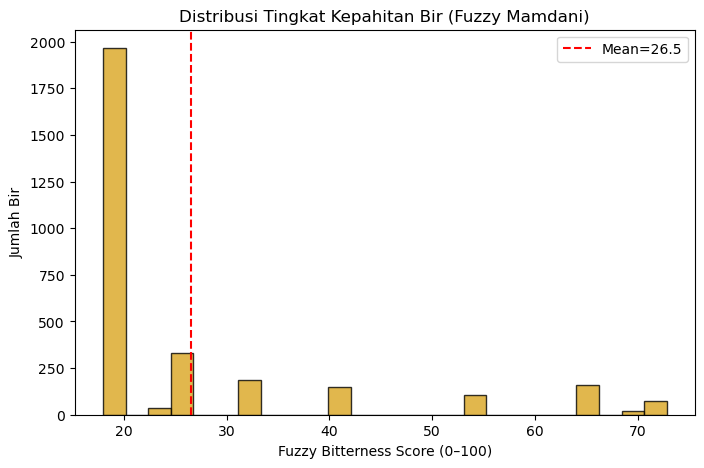

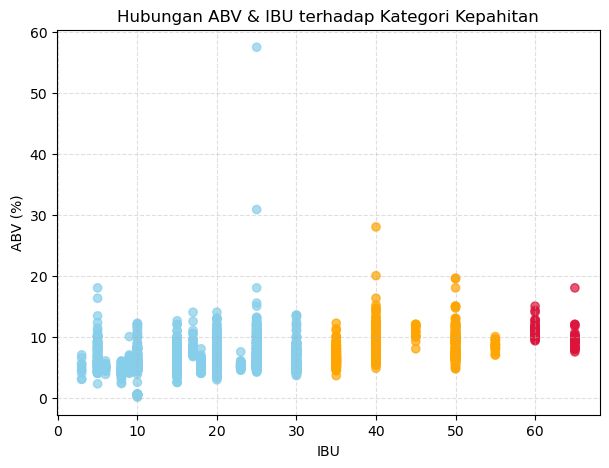

✅ Top 10 beers saved as top-beers.csv


,Min IBU,ABV,bitterness_score,bitterness_category
927,65,18.0,72.796508,Strong
948,65,10.0,72.761905,Strong
950,65,12.0,72.761905,Strong
949,65,10.0,72.761905,Strong
952,65,9.0,72.761905,Strong
953,65,8.3,72.761905,Strong
954,65,8.0,72.761905,Strong
955,65,8.5,72.761905,Strong
956,65,11.7,72.761905,Strong
957,65,9.0,72.761905,Strong


In [8]:
avg = beer_df['bitterness_score'].mean()
strong_pct = (beer_df['bitterness_category'] == "Strong").mean() * 100
mild_pct = (beer_df['bitterness_category'] == "Mild").mean() * 100

print("=== INSIGHT ===")
print(f"Rata-rata tingkat kepahitan: {avg:.2f}")
print(f"Bir 'Strong'  : {strong_pct:.1f}%")
print(f"Bir 'Mild'    : {mild_pct:.1f}%")
print("================")

# Plot distribusi
plt.figure(figsize=(8,5))
plt.hist(beer_df['bitterness_score'], bins=25, color='goldenrod', edgecolor='black', alpha=0.8)
plt.axvline(avg, color='red', linestyle='--', label=f"Mean={avg:.1f}")
plt.title("Distribusi Tingkat Kepahitan Bir (Fuzzy Mamdani)")
plt.xlabel("Fuzzy Bitterness Score (0–100)")
plt.ylabel("Jumlah Bir")
plt.legend()
plt.show()

# Scatter ABV vs IBU
plt.figure(figsize=(7,5))
colors = {'Mild':'skyblue', 'Moderate':'orange', 'Strong':'crimson'}
plt.scatter(beer_df[ibu_col], beer_df[abv_col], c=beer_df['bitterness_category'].map(colors), alpha=0.7)
plt.xlabel("IBU")
plt.ylabel("ABV (%)")
plt.title("Hubungan ABV & IBU terhadap Kategori Kepahitan")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# Top 10
top_beers = beer_df.sort_values(by='bitterness_score', ascending=False).head(10)
top_beers.to_csv("top-beers.csv", index=False)
print("✅ Top 10 beers saved as top-beers.csv")
top_beers[[ibu_col, abv_col, 'bitterness_score', 'bitterness_category']]


Variabilitas Skor Pahit per Kelompok ABV:


,ABV_Group,mean,std
0,Low ABV,19.656562,4.317262
1,Medium ABV,22.253298,8.935975
2,High ABV,33.260203,19.217861


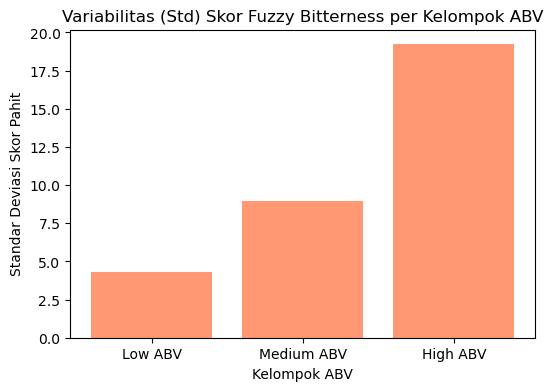

In [13]:
ins = [0, 4.5, 6.5, 12]
labels = ['Low ABV', 'Medium ABV', 'High ABV']
beer_df['ABV_Group'] = pd.cut(beer_df[abv_col], bins=bins, labels=labels)

var_by_group = (
    beer_df.groupby('ABV_Group', observed=False)['bitterness_score']
    .agg(['mean', 'std'])
    .reset_index()
)

print("Variabilitas Skor Pahit per Kelompok ABV:")
display(var_by_group)

plt.figure(figsize=(6,4))
plt.bar(var_by_group['ABV_Group'], var_by_group['std'], color='coral', alpha=0.8)
plt.title("Variabilitas (Std) Skor Fuzzy Bitterness per Kelompok ABV")
plt.xlabel("Kelompok ABV")
plt.ylabel("Standar Deviasi Skor Pahit")
plt.show()